In [93]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import aesara.tensor as at
import arviz as az
import matplotlib.pyplot as plt
import models
import numpy as np
import os.path as op
import pymc as pm
import seaborn as sns
from tqdm import tqdm
import xarray as xr

sns.set_context('notebook')
sns.set_palette('colorblind')

# Set to `True` when you want to update the saved chains; `False` allows to play around without corrupting the saved chains.
save_chains = True
outdir = op.join("..", "data")

# Number of events to analyze
Ncatalog = 128

We have a realistic, but simplified model for how inclination-distance measurements are made in LIGO.  We imagine that our detector network measures the amplitudes of the R and L polarizations independently; these are related to the inclination ($x = \cos \iota$) and distance $d$ via 
$$
A_{R/L} = \frac{\left( 1 \pm x \right)^2}{d}.
$$
The network measures a projection of these with coefficients $f_{R/L}$ with unit amplitude Gaussian noise:
$$
A_{R/L,\mathrm{obs}} = f_{R/L} A_{R/L} + N(0,1).
$$
Setting $f_R = f_L = 1$ means the network is equally sensitive to both polarizations (i.e. two randomly-oriented, equally-sensitive detectors); setting these to different values means the network measures one polarization better than the other (i.e. for two nearly-aligned, equally-sensitive detectors, or two randomly-oriented detectors with different sensitivities).

The S/N for a given signal is given by
$$
\rho^2 = \frac{A_{R,\mathrm{obs}}^2 + A_{L,\mathrm{obs}}^2}{2}.
$$
We assume that $\rho > 10$ is a condition for a GW "detection."

We further assume that the EM emissions from these merger events are not uniform over viewing angle, so that the detection of EM emission from an event carries information about the inclination.  That is, we imagine that the EM likelihood depends on inclination *and* redshift
$$
p\left( d_\mathrm{EM} \mid z, \iota \right) \propto \delta\left( z_\mathrm{obs} - z \right) \times p\left( d_\mathrm{EM} \mid \iota \right).
$$
Because we don't *know* or have a good model for the emission pattern (or we don't want to introduce this systematic uncertainty into our measurements), we aren't going to *use* the EM data to constrain $\iota$.  Instead, we will just marginalize it out, but subject to the constraint that the emission was detectable (otherwise we wouldn't have a redshift measurement in our catalog).  Detectability can be described by some function $f$ on the data such that $f\left( d_\mathrm{EM} \right) > 0$ when the emission is detectable, and $f < 0$ otherwise.  Thus we write 
$$
\int_{f\left( d_\mathrm{EM} \right) > 0} \mathrm{d} d_\mathrm{EM} \, p\left( d_\mathrm{EM} \mid z, \iota \right) \propto \delta\left( z_\mathrm{obs} - z \right) \int_{f\left( d_\mathrm{EM} \right) > 0} \mathrm{d} d_\mathrm{EM} \, p\left( d_\mathrm{EM} \mid \iota \right) = \delta\left( z_\mathrm{obs} - z \right) P_\mathrm{det}\left( \iota \right),
$$
where $P_\mathrm{det}\left( \iota \right)$ is the fraction of EM data that would be detectable at inclination $\iota$ out of all possible EM data produced at inclination $\iota$.  The delta-function and $P_\mathrm{det}$ then multiply the GW likelihood for distance and inclination in our analysis; $P_\mathrm{det}$ therefore functions to modulate the usual GW prior $p\left( \cos \iota \right) = p\left( x \right) \propto \mathrm{const}$.

We do not know $P_\mathrm{det}\left( \iota \right)$, but we can model it.  Here we choose to model the log-detectability using a series of Legendre polynomials in $x$:
$$
P_\mathrm{det} \propto \exp\left[\sum_{l\geq 1} A_l P_l\left( x \right) \right]
$$
We fix the normalization by enforcing $A_0 = 0$---the modulated prior will, ultimately, get normalized over detectable *GW* signals anyway.  We fix $0 < l \leq 2$ for our example here.  We exponentiate so that the detection probability is always positive.

Let's generate some mock data.  We choose $A = (0, 1)$ which gives the detectability the following shape:

Text(0, 0.5, '$P_\\mathrm{det}(x)$')

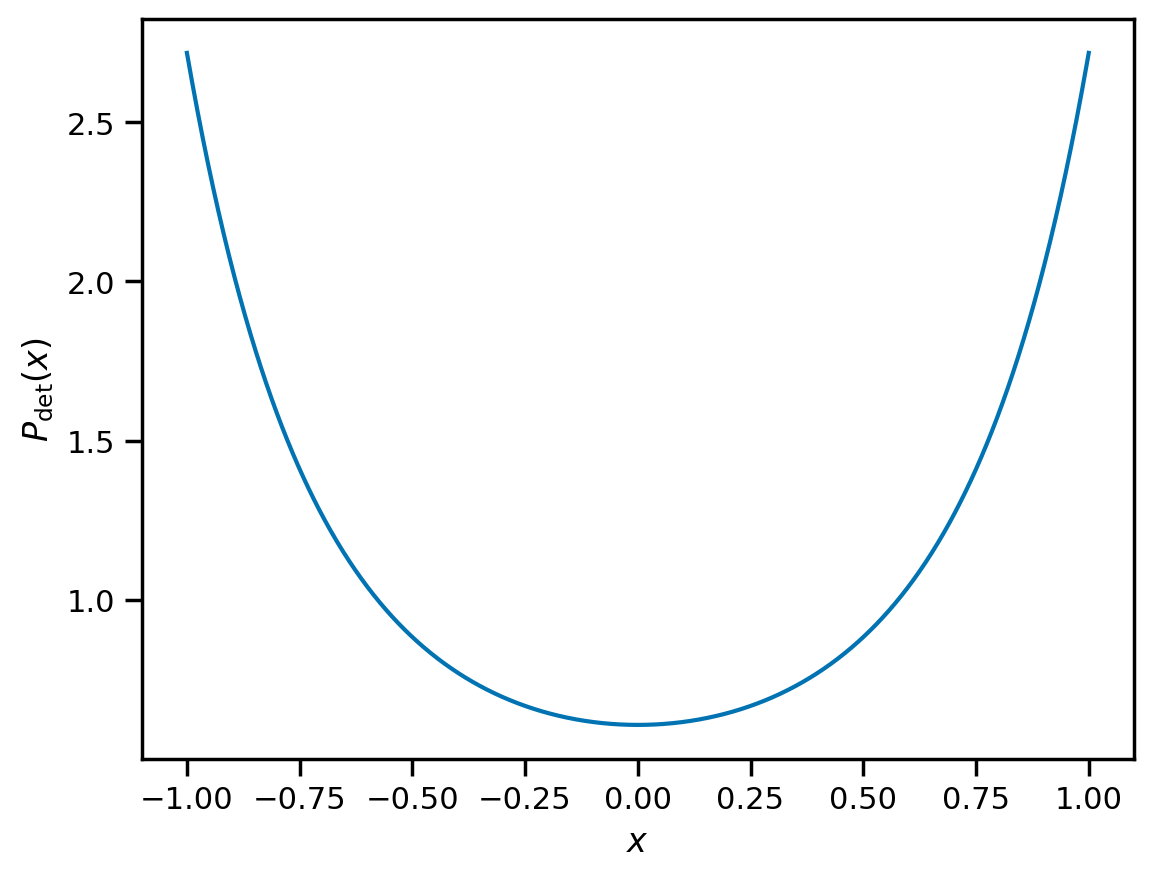

In [2]:
x = np.linspace(-1, 1, 1024)

A1_true = 0.0
A2_true = 1.0
A_true = [A1_true, A2_true]

plt.plot(x, models.P_det(x, A_true))
plt.xlabel(r'$x$')
plt.ylabel(r'$P_\mathrm{det}(x)$')

In [3]:
N = 2048
(em_detected, x_true, d_true, z_true, Al_true, Ar_true, Al, Ar, Ndraw) = models.draw_gws(lambda x: models.P_det(x, A_true), N)

100%|██████████| 2048/2048 [00:01<00:00, 1621.23it/s]


Let's check the distribution of detected distances, detected inclinations, EM-detected inclinations, etc:

Text(0, 0.5, '$p\\left( x \\mid \\mathrm{GWdet} \\right)$')

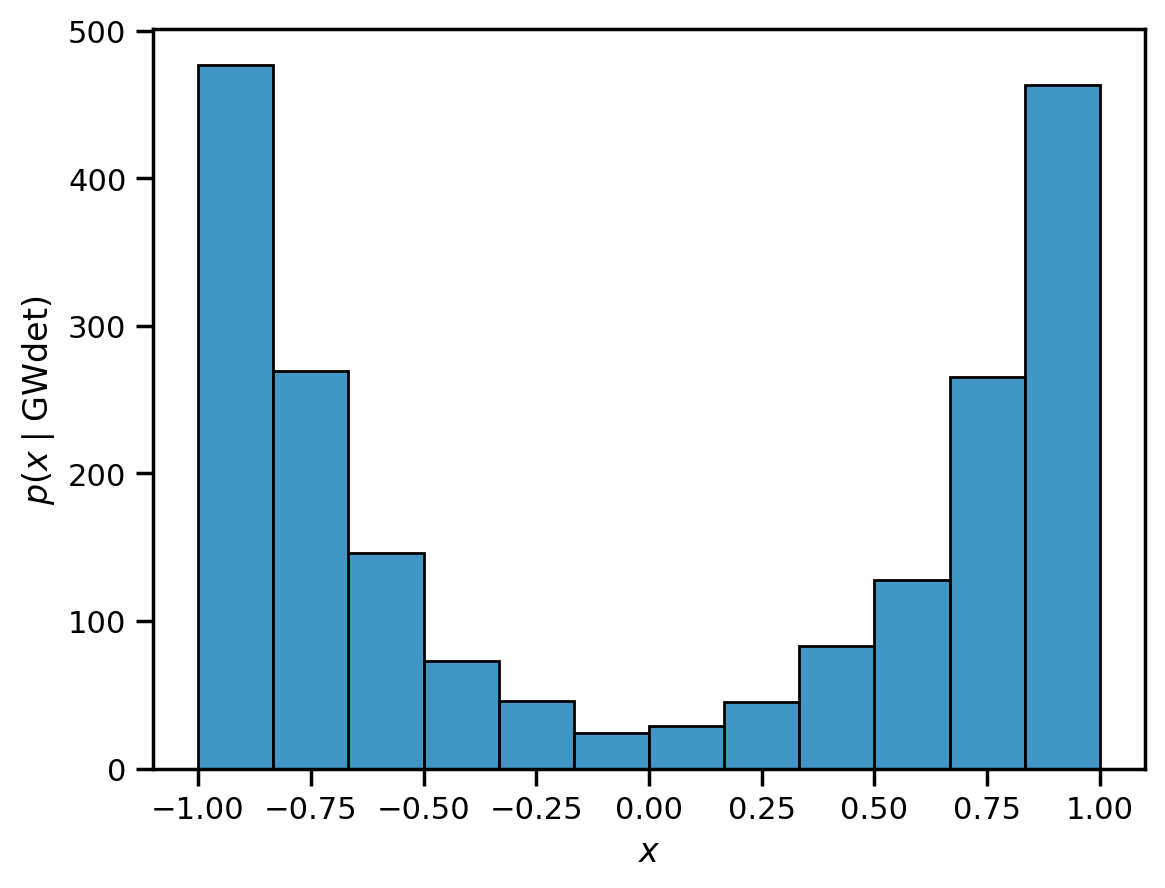

In [4]:
sns.histplot(x_true)
plt.xlabel(r'$x$')
plt.ylabel(r'$p\left( x \mid \mathrm{GWdet} \right)$')

Note that our distance distribution truncates well before $d_\mathrm{max} = 0.5$ (the default maximum distance to draw):

Text(0, 0.5, '$p\\left( d \\mid \\mathrm{GWdet} \\right)$')

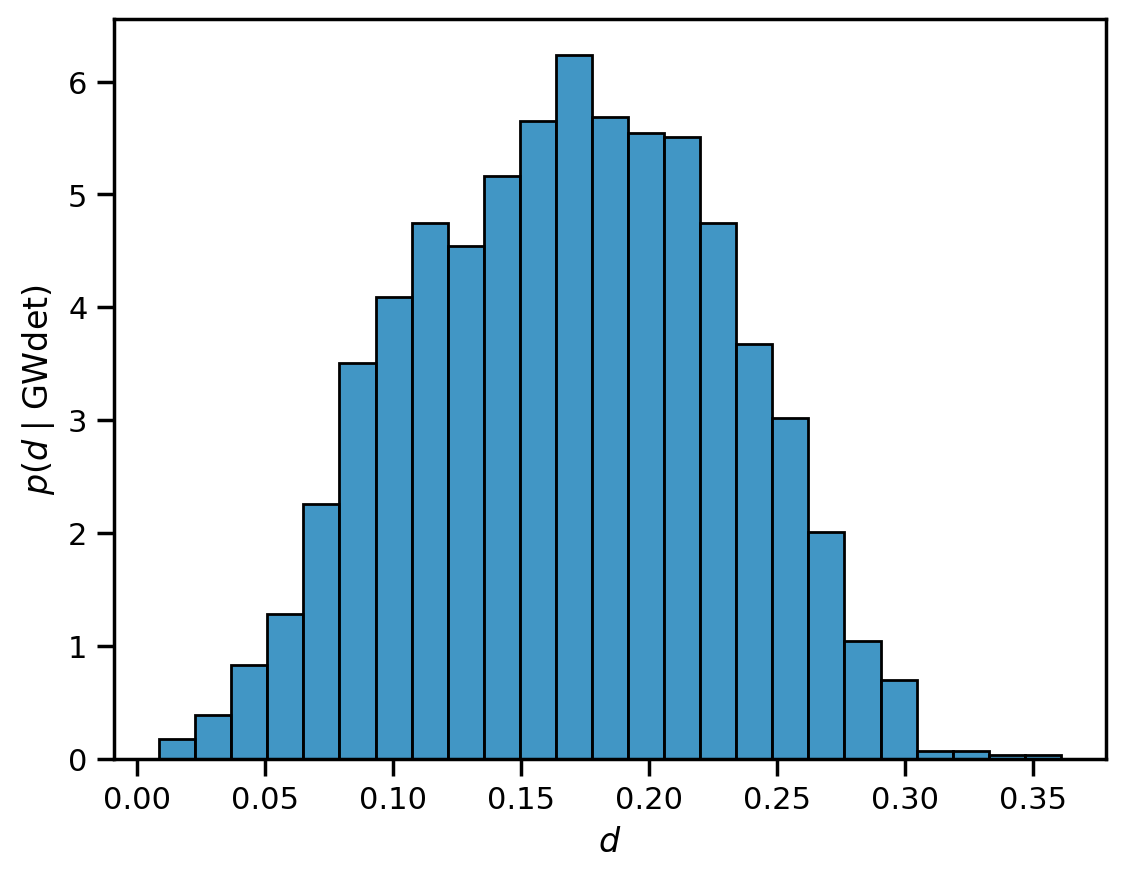

In [5]:
sns.histplot(d_true, stat='density')
plt.xlabel(r'$d$')
plt.ylabel(r'$p\left( d \mid \mathrm{GWdet} \right)$')

What about the inclination distribution for events that are *also* EM detected?

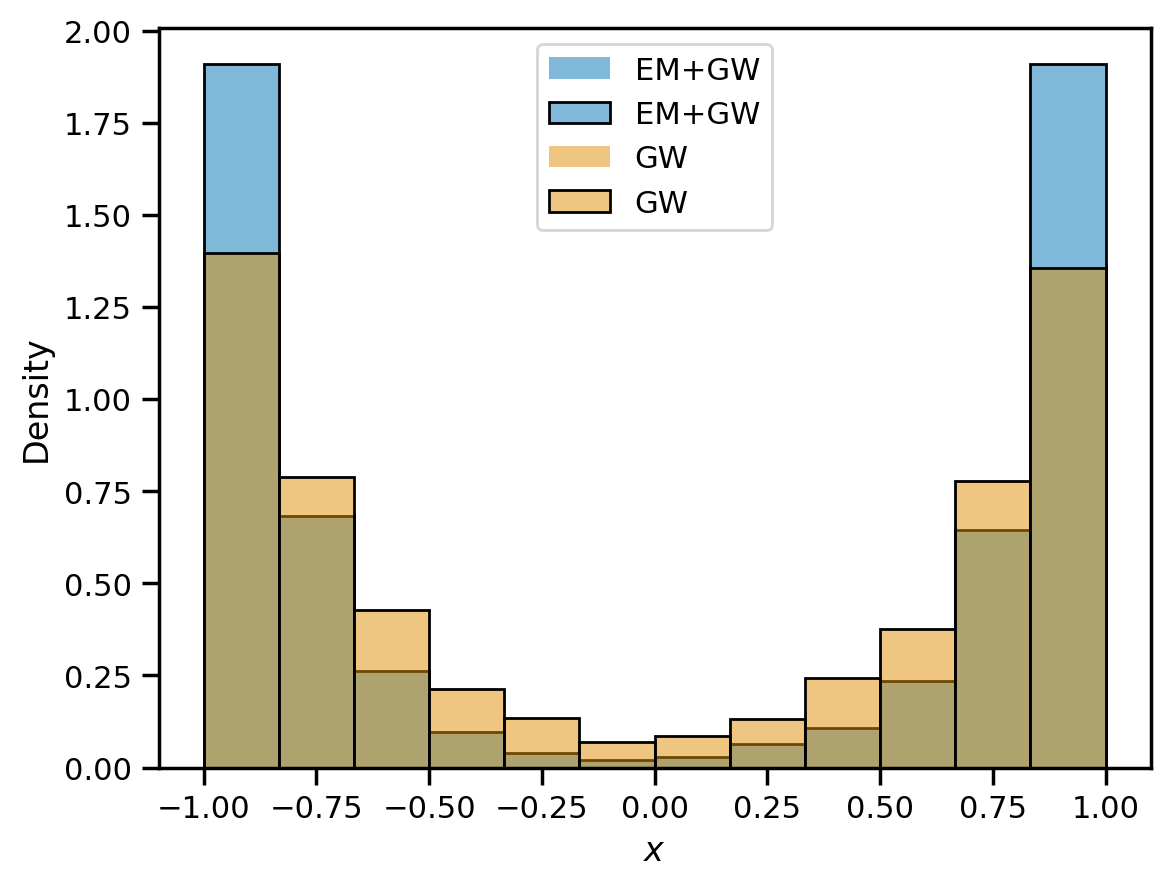

In [6]:
sns.histplot([x for (x, e) in zip(x_true, em_detected) if e], label='EM+GW', alpha=0.5, stat='density')
sns.histplot(x_true, label='GW', alpha=0.5, stat='density')
plt.xlabel(r'$x$')
plt.legend()

Now we build a model of the measurement process, including the perfect measurement of $z$.  The distance prior is proportional to $d^2$, the inclination prior proportional to $P_\mathrm{det}(x)$.  Integrating across the delta-function measurement of $z$ gives 
$$
\int \mathrm{d} d \, \delta\left( z - d h \right) d^2 = \frac{z^2}{h^3}
$$

We use the method described in [Farr (2019)](https://ui.adsabs.harvard.edu/abs/2019RNAAS...3...66F/abstract) to account for the GW selection effects; the draw probability is proportional to $d^2$ and constant in $x$, so we have in the notation of that paper 
$$
\frac{\xi\left( d, x \mid A_l \right)}{p_\mathrm{draw}\left( d, x \right)} = P_\mathrm{det}\left( x \mid A_l \right).
$$

In [7]:
z_obs = z_true[em_detected][:Ncatalog]
Al_obs = Al[em_detected][:Ncatalog]
Ar_obs = Ar[em_detected][:Ncatalog]

In [8]:
with models.make_model(z_obs, Al_obs, Ar_obs, x_true, Ndraw) as model:
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [h, A, x]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 81 seconds.


The sampling looks pretty good:

In [9]:
az.summary(trace)

mean       sd    hdi_3%   hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
A[1]      -0.160    0.103    -0.345     0.031      0.002    0.002    2646.0   
A[2]       1.257    0.276     0.752     1.775      0.008    0.006    1320.0   
h          0.703    0.006     0.692     0.713      0.000    0.000     487.0   
x[0]       0.939    0.046     0.855     1.000      0.001    0.001    1417.0   
x[1]      -0.958    0.036    -1.000    -0.893      0.001    0.000    1921.0   
...          ...      ...       ...       ...        ...      ...       ...   
d[124]     0.106    0.001     0.104     0.107      0.000    0.000     487.0   
d[125]     0.295    0.002     0.290     0.299      0.000    0.000     487.0   
d[126]     0.255    0.002     0.251     0.259      0.000    0.000     487.0   
d[127]     0.224    0.002     0.221     0.228      0.000    0.000     487.0   
Neff    1577.374  105.756  1392.447  1791.837      2.852    2.017    1408.0   

        ess_tail  r_hat  
A[1]      1473.0   1.00  
A[2]      1141.0   1.00  
h          581.0   1.01  
x[0]       752.0   1.00  
x[1]       799.0   1.00  
...          ...    ...  
d[124]     581.0   1.01  
d[125]     581.0   1.01  
d[126]     581.0   1.01  
d[127]     581.0   1.01  
Neff       870.0   1.00  

[260 rows x 9 columns]

And the parameters come out OK:

array([[<AxesSubplot: title={'center': 'A'}>,
        <AxesSubplot: title={'center': 'A'}>],
       [<AxesSubplot: title={'center': 'h'}>,
        <AxesSubplot: title={'center': 'h'}>],
       [<AxesSubplot: title={'center': 'x'}>,
        <AxesSubplot: title={'center': 'x'}>],
       [<AxesSubplot: title={'center': 'd'}>,
        <AxesSubplot: title={'center': 'd'}>],
       [<AxesSubplot: title={'center': 'Neff'}>,
        <AxesSubplot: title={'center': 'Neff'}>]], dtype=object)

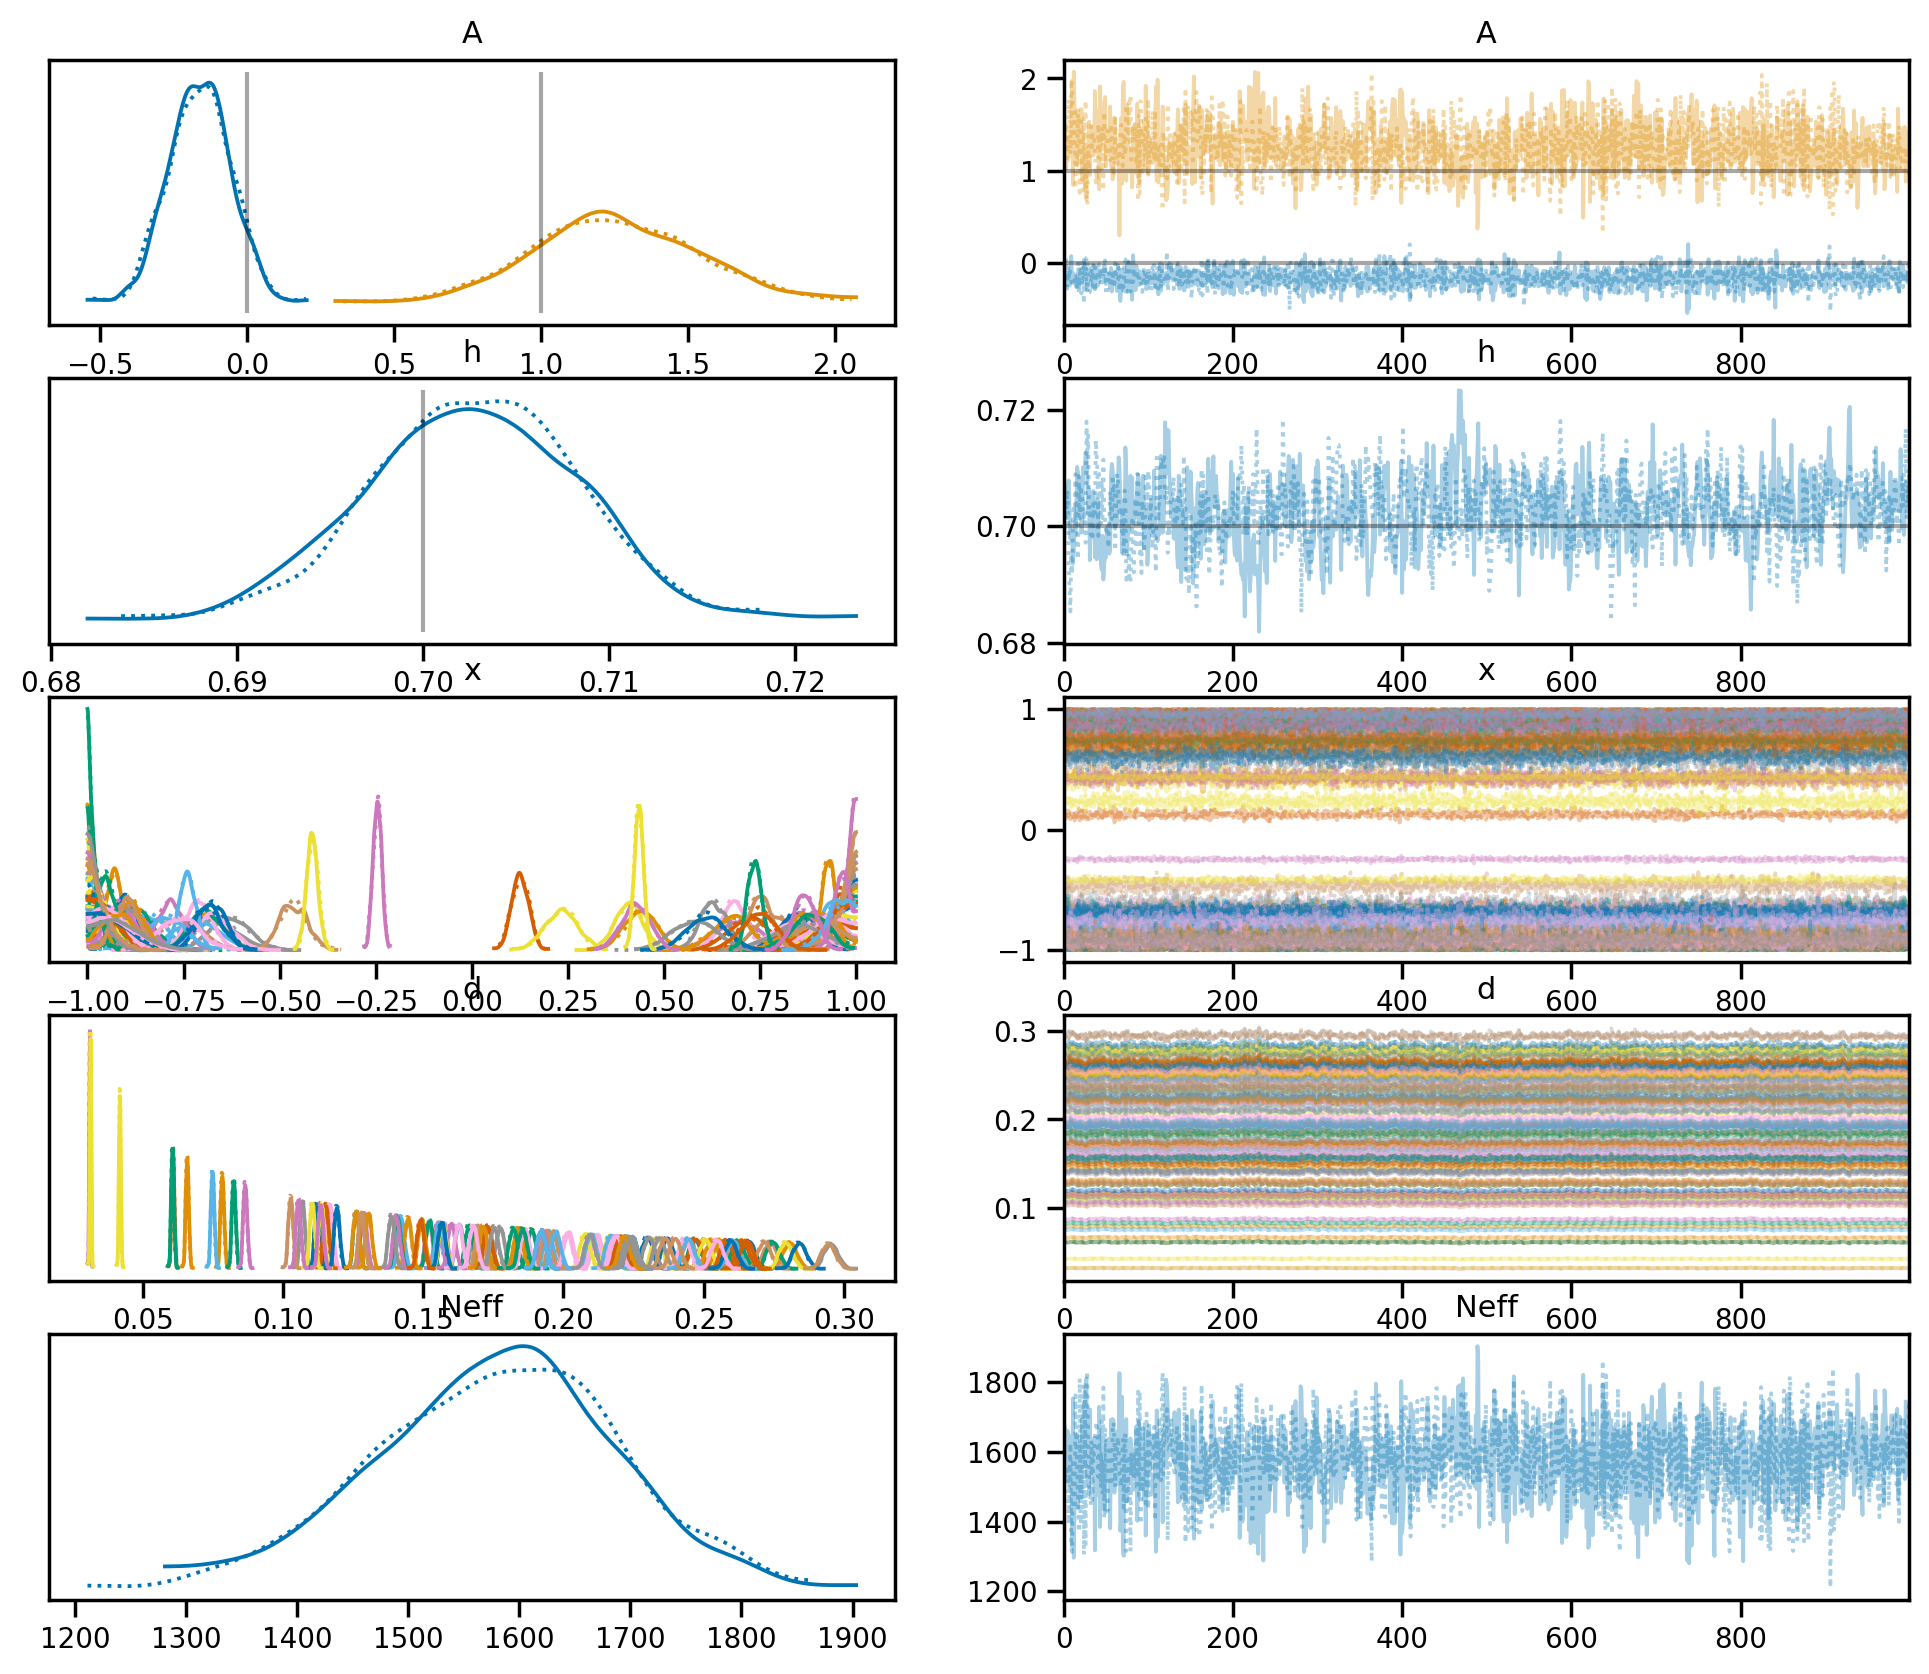

In [10]:
az.plot_trace(trace, lines=[('h', {}, 0.7), ('A', {}, A_true)])

Let's calculate the inferred distribution of inclinations:

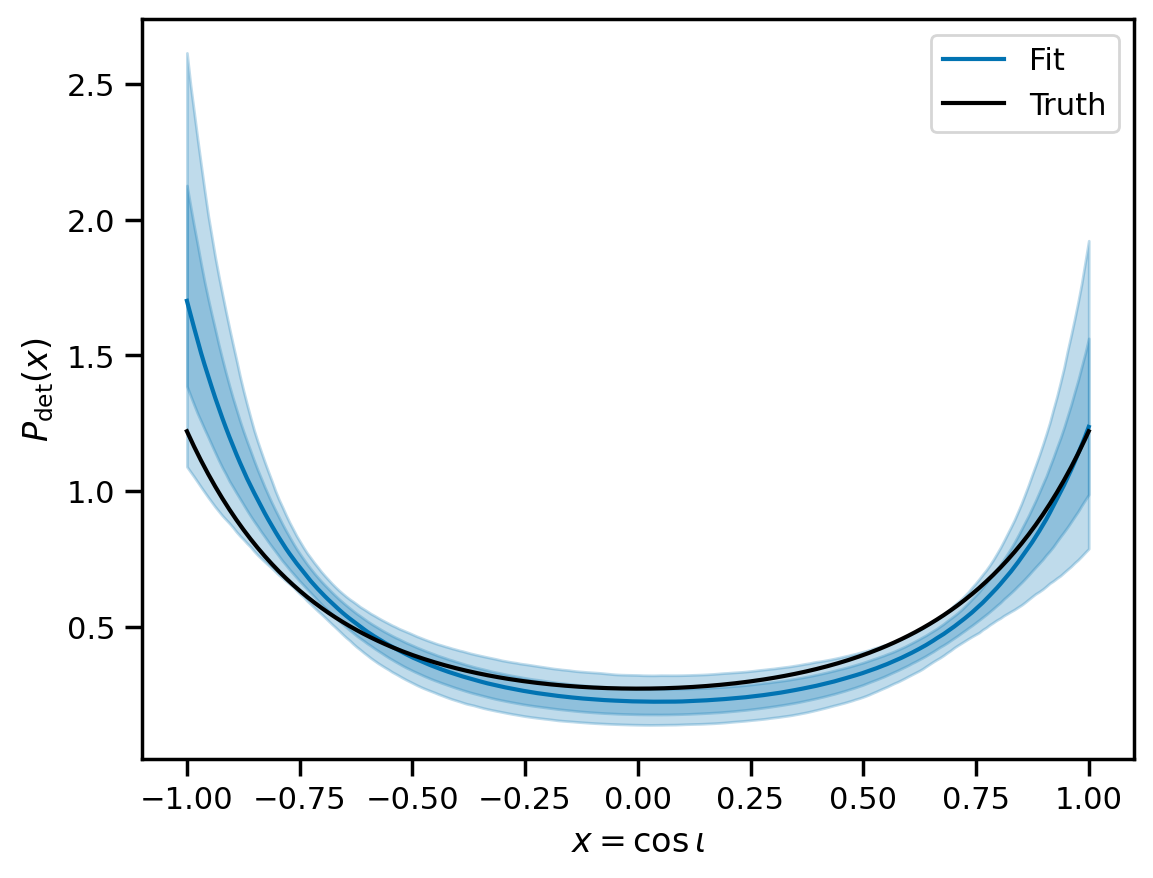

In [11]:
models.calculate_P_det(trace) # Need to compute P_det
pds = trace.posterior.P_det
x = pds.coords['x']

dim = ['chain', 'draw']
l, = plt.plot(x,pds.median(dim=dim), label='Fit')
plt.fill_between(x, pds.quantile(0.84, dim=dim), pds.quantile(0.16, dim=dim), color=l.get_color(), alpha=0.25)
plt.fill_between(x, pds.quantile(0.975, dim=dim), pds.quantile(0.025, dim=dim), color=l.get_color(), alpha=0.25)
plt.plot(x, models.P_det(x, A_true) / np.trapz(models.P_det(x, A_true), x), color='k', label='Truth')
plt.xlabel(r'$x = \cos\iota$')
plt.ylabel(r'$P_\mathrm{det}(x)$')
plt.legend()

And what about the Hubble constant?

<AxesSubplot: title={'center': 'h'}>

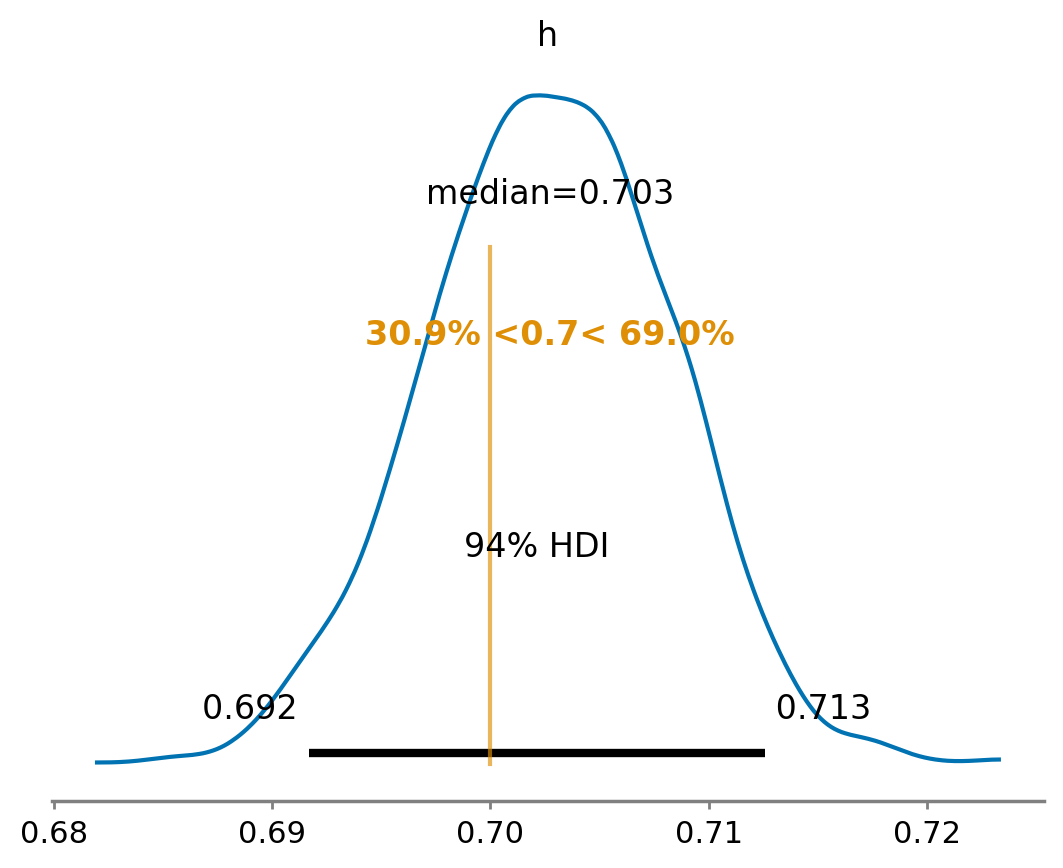

In [12]:
az.plot_posterior(trace, var_names='h', ref_val=0.7, point_estimate='median', round_to=3)

Save our trace.

In [13]:
if save_chains:
    az.to_netcdf(trace, op.join(outdir, 'Pl_2_chains.nc'))

What happens if we instead fix the inclination distribution to the correct value?

In [14]:
with models.make_model(z_obs, Al_obs, Ar_obs, x_true, Ndraw, fix_A=A_true) as fixed_model:
    fixed_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [h, x]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 42 seconds.


And what if we don't fit the inclination distribution at all?

In [15]:
with models.make_model(z_obs, Al_obs, Ar_obs, x_true, Ndraw, fix_A=np.zeros(2)) as no_fit_model:
    no_fit_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [h, x]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 59 seconds.


There doesn't seem to be very much difference in the measurement of $h$:

Text(0.5, 0, '$h$')

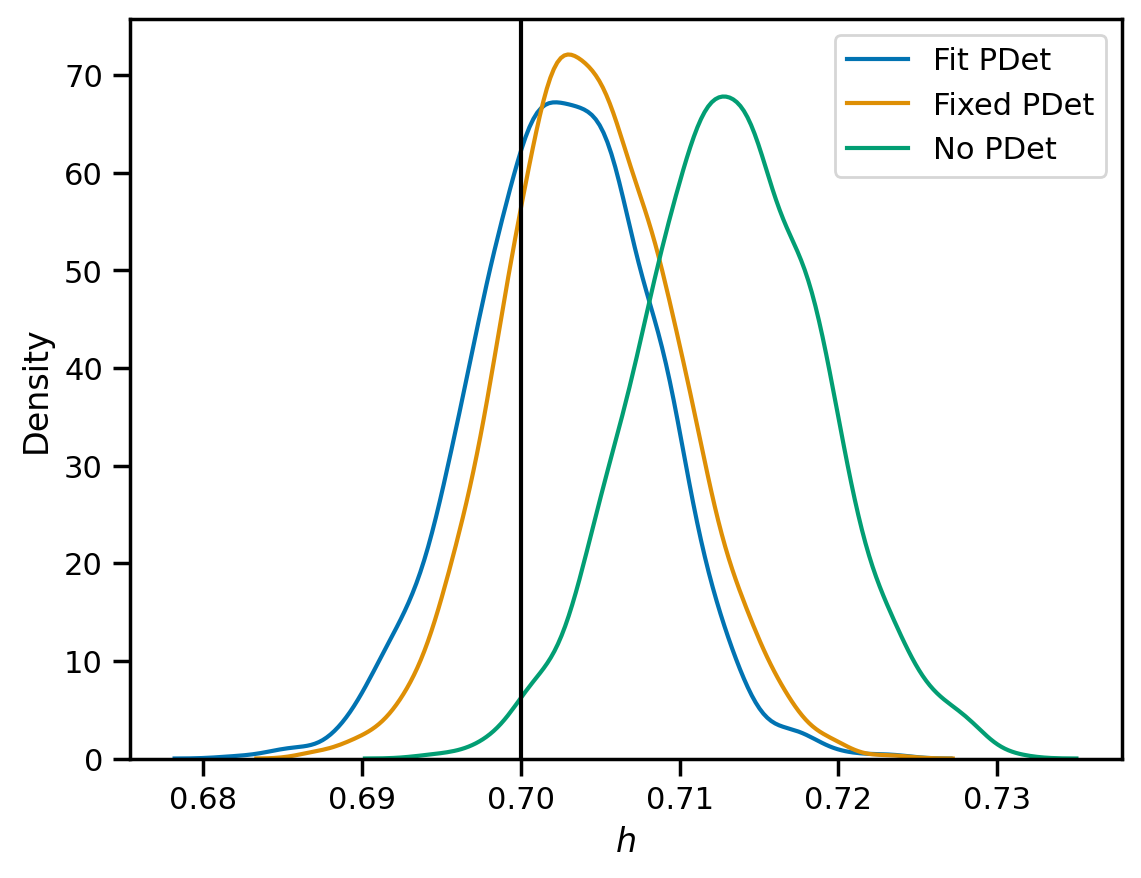

In [17]:
d = ['chain', 'draw']
sns.kdeplot(trace.posterior.h.stack(dim=d), label='Fit PDet')
sns.kdeplot(fixed_trace.posterior.h.stack(dim=d), label='Fixed PDet')
sns.kdeplot(no_fit_trace.posterior.h.stack(dim=d), label='No PDet')
plt.axvline(0.7, color='k')
plt.legend()
plt.xlabel(r'$h$')

Save the data:

In [18]:
if save_chains:
    az.to_netcdf(fixed_trace, op.join(outdir, 'Pl_2_fixed_chains.nc'))
    az.to_netcdf(no_fit_trace, op.join(outdir, 'Pl_2_no_fit_chains.nc'))

What if we now try a selection function model where $P_\mathrm{det}$ has some mild angular dependence for half the events plus a top hat near the poles, say with opening angle $20^\circ$.  We will make it so that each component comprises one half of the observed events.

Text(0, 0.5, '$P_\\mathrm{det}(x)$')

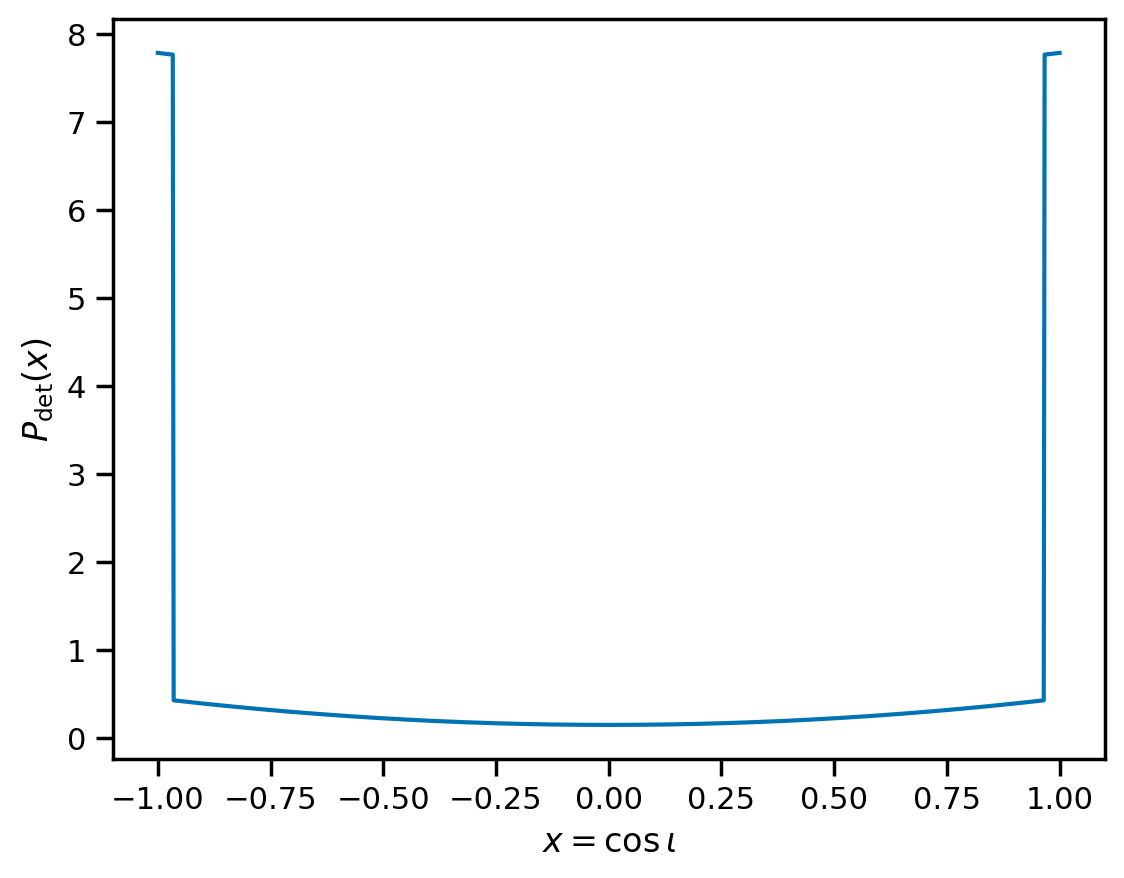

In [86]:
opening_angle = 15
xmin = np.cos(opening_angle*np.pi/180)
top_hat_fraction = 0.5
def Pdet_top_hat(x):
    x = np.atleast_1d(x)
    p_broad = 3*(x*x + 0.5)/5
    p_narrow = np.where(np.abs(x)>xmin, 0.5/(1-xmin), 0)

    return (1-top_hat_fraction)*p_broad+top_hat_fraction*p_narrow
x = np.linspace(-1, 1, 1024)
plt.plot(x, Pdet_top_hat(x))
plt.xlabel(r'$x = \cos \iota$')
plt.ylabel(r'$P_\mathrm{det}(x)$')

We generate a data set from this EM selection effect:

In [87]:
N = 2048
(em_detected, x_true, d_true, z_true, Al_true, Ar_true, Al, Ar, Ndraw) = models.draw_gws(Pdet_top_hat, N)

100%|██████████| 2048/2048 [00:00<00:00, 3577.89it/s]


Let's compare the observed distributions of $x$:

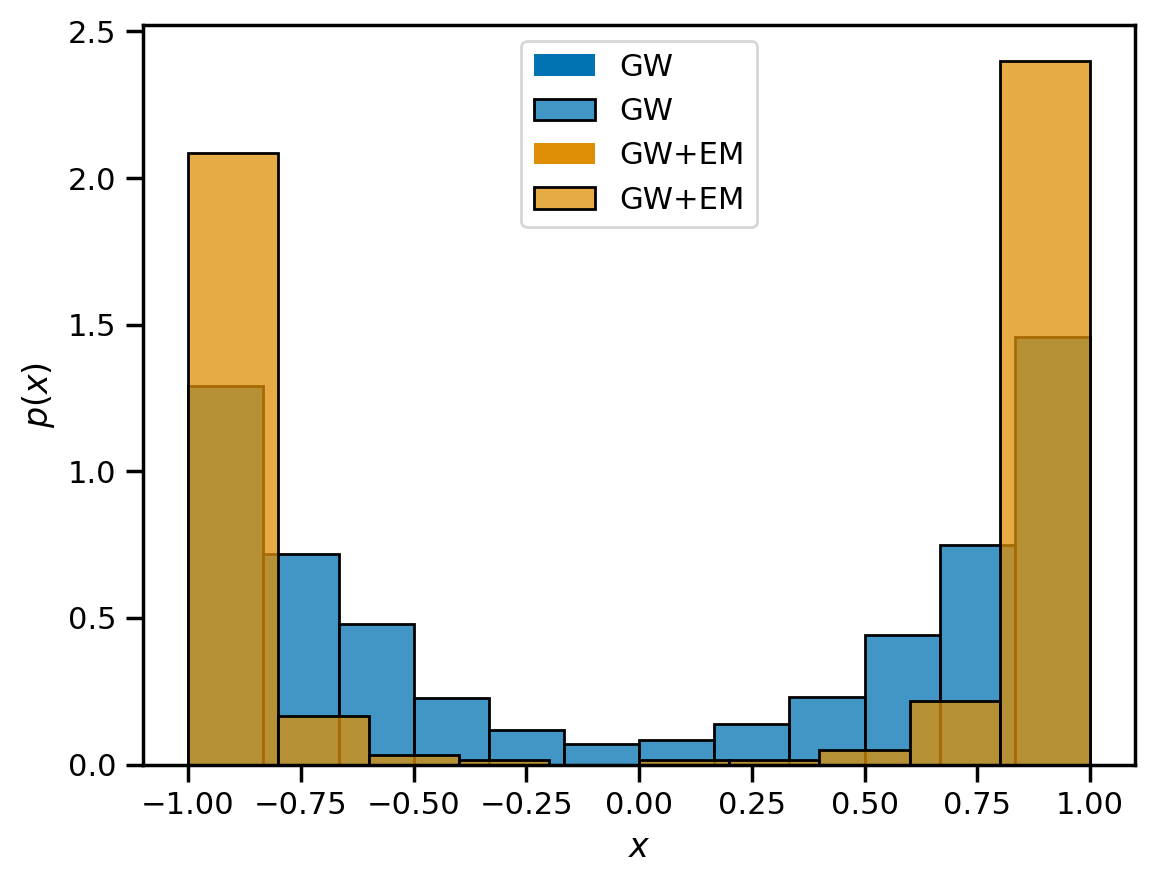

In [88]:
sns.histplot(x_true, label='GW', stat='density')
sns.histplot(x_true[em_detected], label='GW+EM', stat='density')
plt.xlabel(r'$x$')
plt.ylabel(r'$p(x)$')
plt.legend()

Let's try fitting this with up to $P_4$ (the "broad" detection efficiency is a combination of $P_2$ and $P_0$; the narrow one is also symmetric about $x = 0$, so $P_3$ is not helpful).

In [89]:
with models.make_model(z_true[em_detected][1:Ncatalog], Al[em_detected][1:Ncatalog], Ar[em_detected][1:Ncatalog], x_true, Ndraw, N_A=4) as top_hat_model:
    top_hat_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [h, A, x]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 40 seconds.


Compute $P_\mathrm{det}$:

In [90]:
models.calculate_P_det(top_hat_trace)

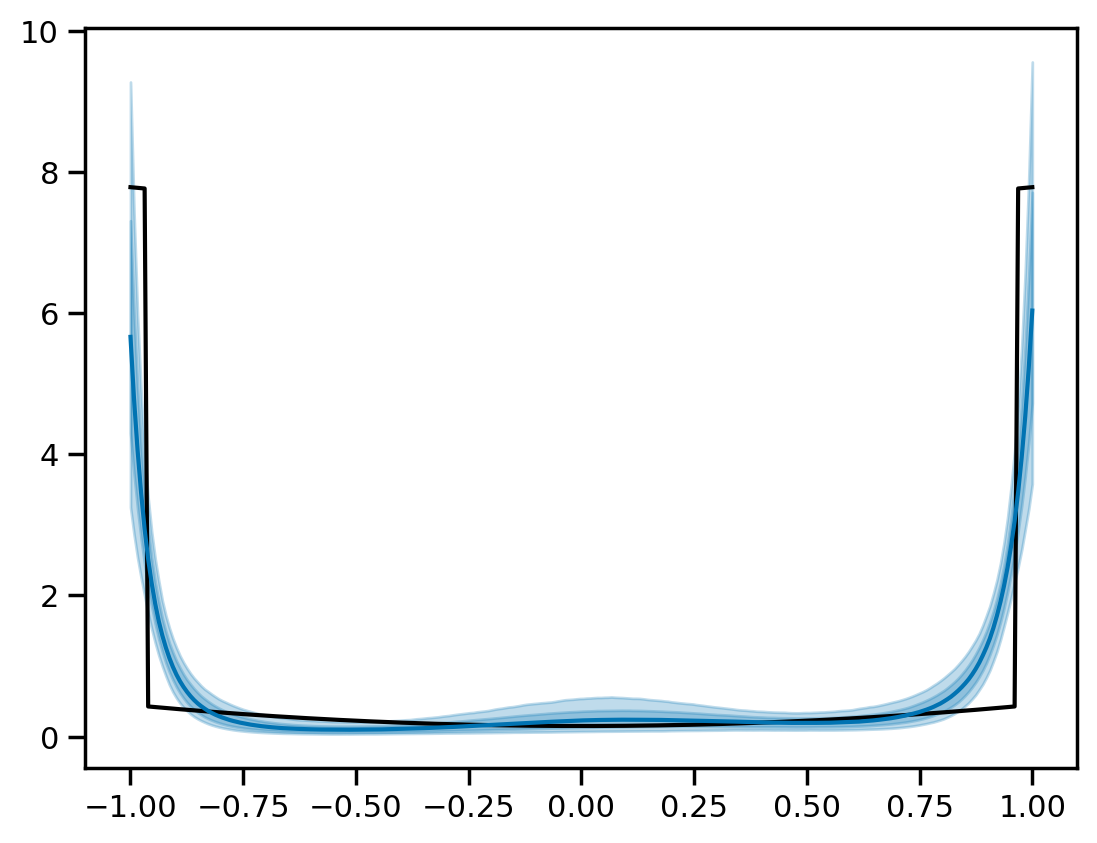

In [91]:
pd = top_hat_trace.posterior.P_det
x = pd.coords['x']
d = ['chain', 'draw']
plt.plot(x, Pdet_top_hat(x), '-k', label='Truth')
l, plt.plot(x, pd.median(dim=d), label='Fit')
plt.fill_between(x, pd.quantile(0.84, dim=d), pd.quantile(0.16, dim=d), alpha=0.25, color=l.get_color())
plt.fill_between(x, pd.quantile(0.975, dim=d), pd.quantile(0.025, dim=d), alpha=0.25, color=l.get_color())

<AxesSubplot: title={'center': 'h'}>

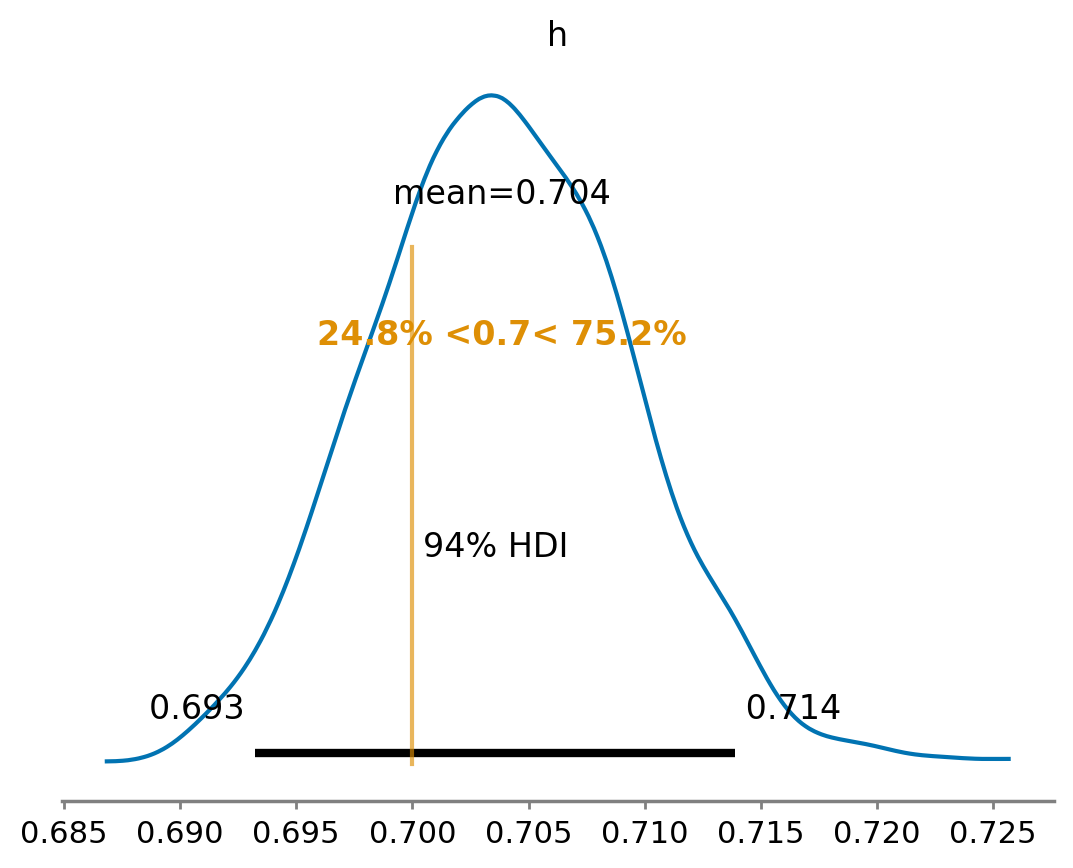

In [92]:
az.plot_posterior(top_hat_trace, var_names='h', ref_val=0.7, round_to=3)

Save this data:

In [94]:
if save_chains:
    az.to_netcdf(top_hat_trace, op.join(outdir, 'top_hat_chains.nc'))

How bad do we do if we fix to the flat inclination distribution?

In [95]:
with models.make_model(z_true[em_detected][1:Ncatalog], Al[em_detected][1:Ncatalog], Ar[em_detected][1:Ncatalog], x_true, Ndraw, fix_A=[0.0, 0.0]):
    top_hat_flat_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [h, x]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 33 seconds.


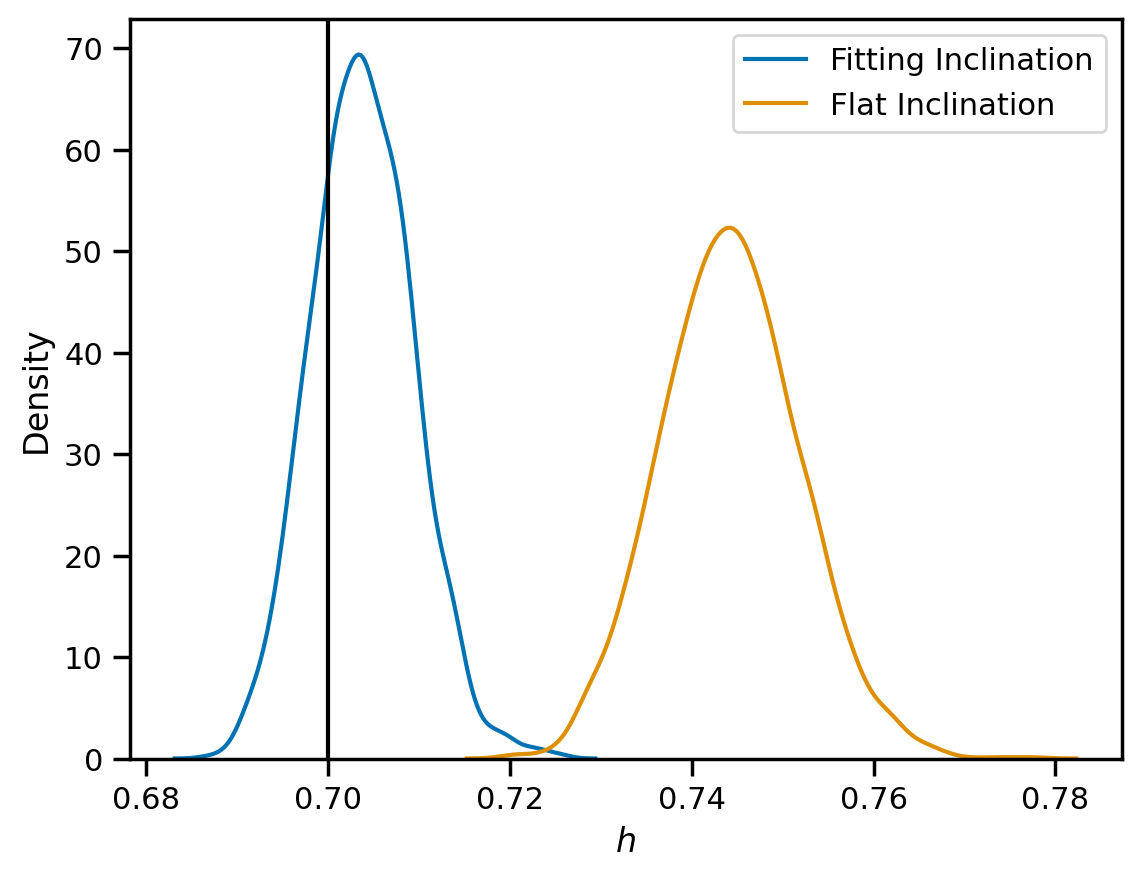

In [96]:
sns.kdeplot(top_hat_trace.posterior.h.stack({'sample': ['chain', 'draw']}), label='Fitting Inclination')
sns.kdeplot(top_hat_flat_trace.posterior.h.stack({'sample': ['chain', 'draw']}), label='Flat Inclination')
plt.axvline(0.7, color='k')
plt.xlabel(r'$h$')
plt.legend()

array([[<AxesSubplot: ylabel='h'>, <AxesSubplot: >, <AxesSubplot: >,
        <AxesSubplot: >, <AxesSubplot: >],
       [<AxesSubplot: ylabel='A\n1'>, <AxesSubplot: >, <AxesSubplot: >,
        <AxesSubplot: >, <AxesSubplot: >],
       [<AxesSubplot: ylabel='A\n2'>, <AxesSubplot: >, <AxesSubplot: >,
        <AxesSubplot: >, <AxesSubplot: >],
       [<AxesSubplot: ylabel='A\n3'>, <AxesSubplot: >, <AxesSubplot: >,
        <AxesSubplot: >, <AxesSubplot: >],
       [<AxesSubplot: xlabel='h', ylabel='A\n4'>,
        <AxesSubplot: xlabel='A\n1'>, <AxesSubplot: xlabel='A\n2'>,
        <AxesSubplot: xlabel='A\n3'>, <AxesSubplot: xlabel='A\n4'>]],
      dtype=object)

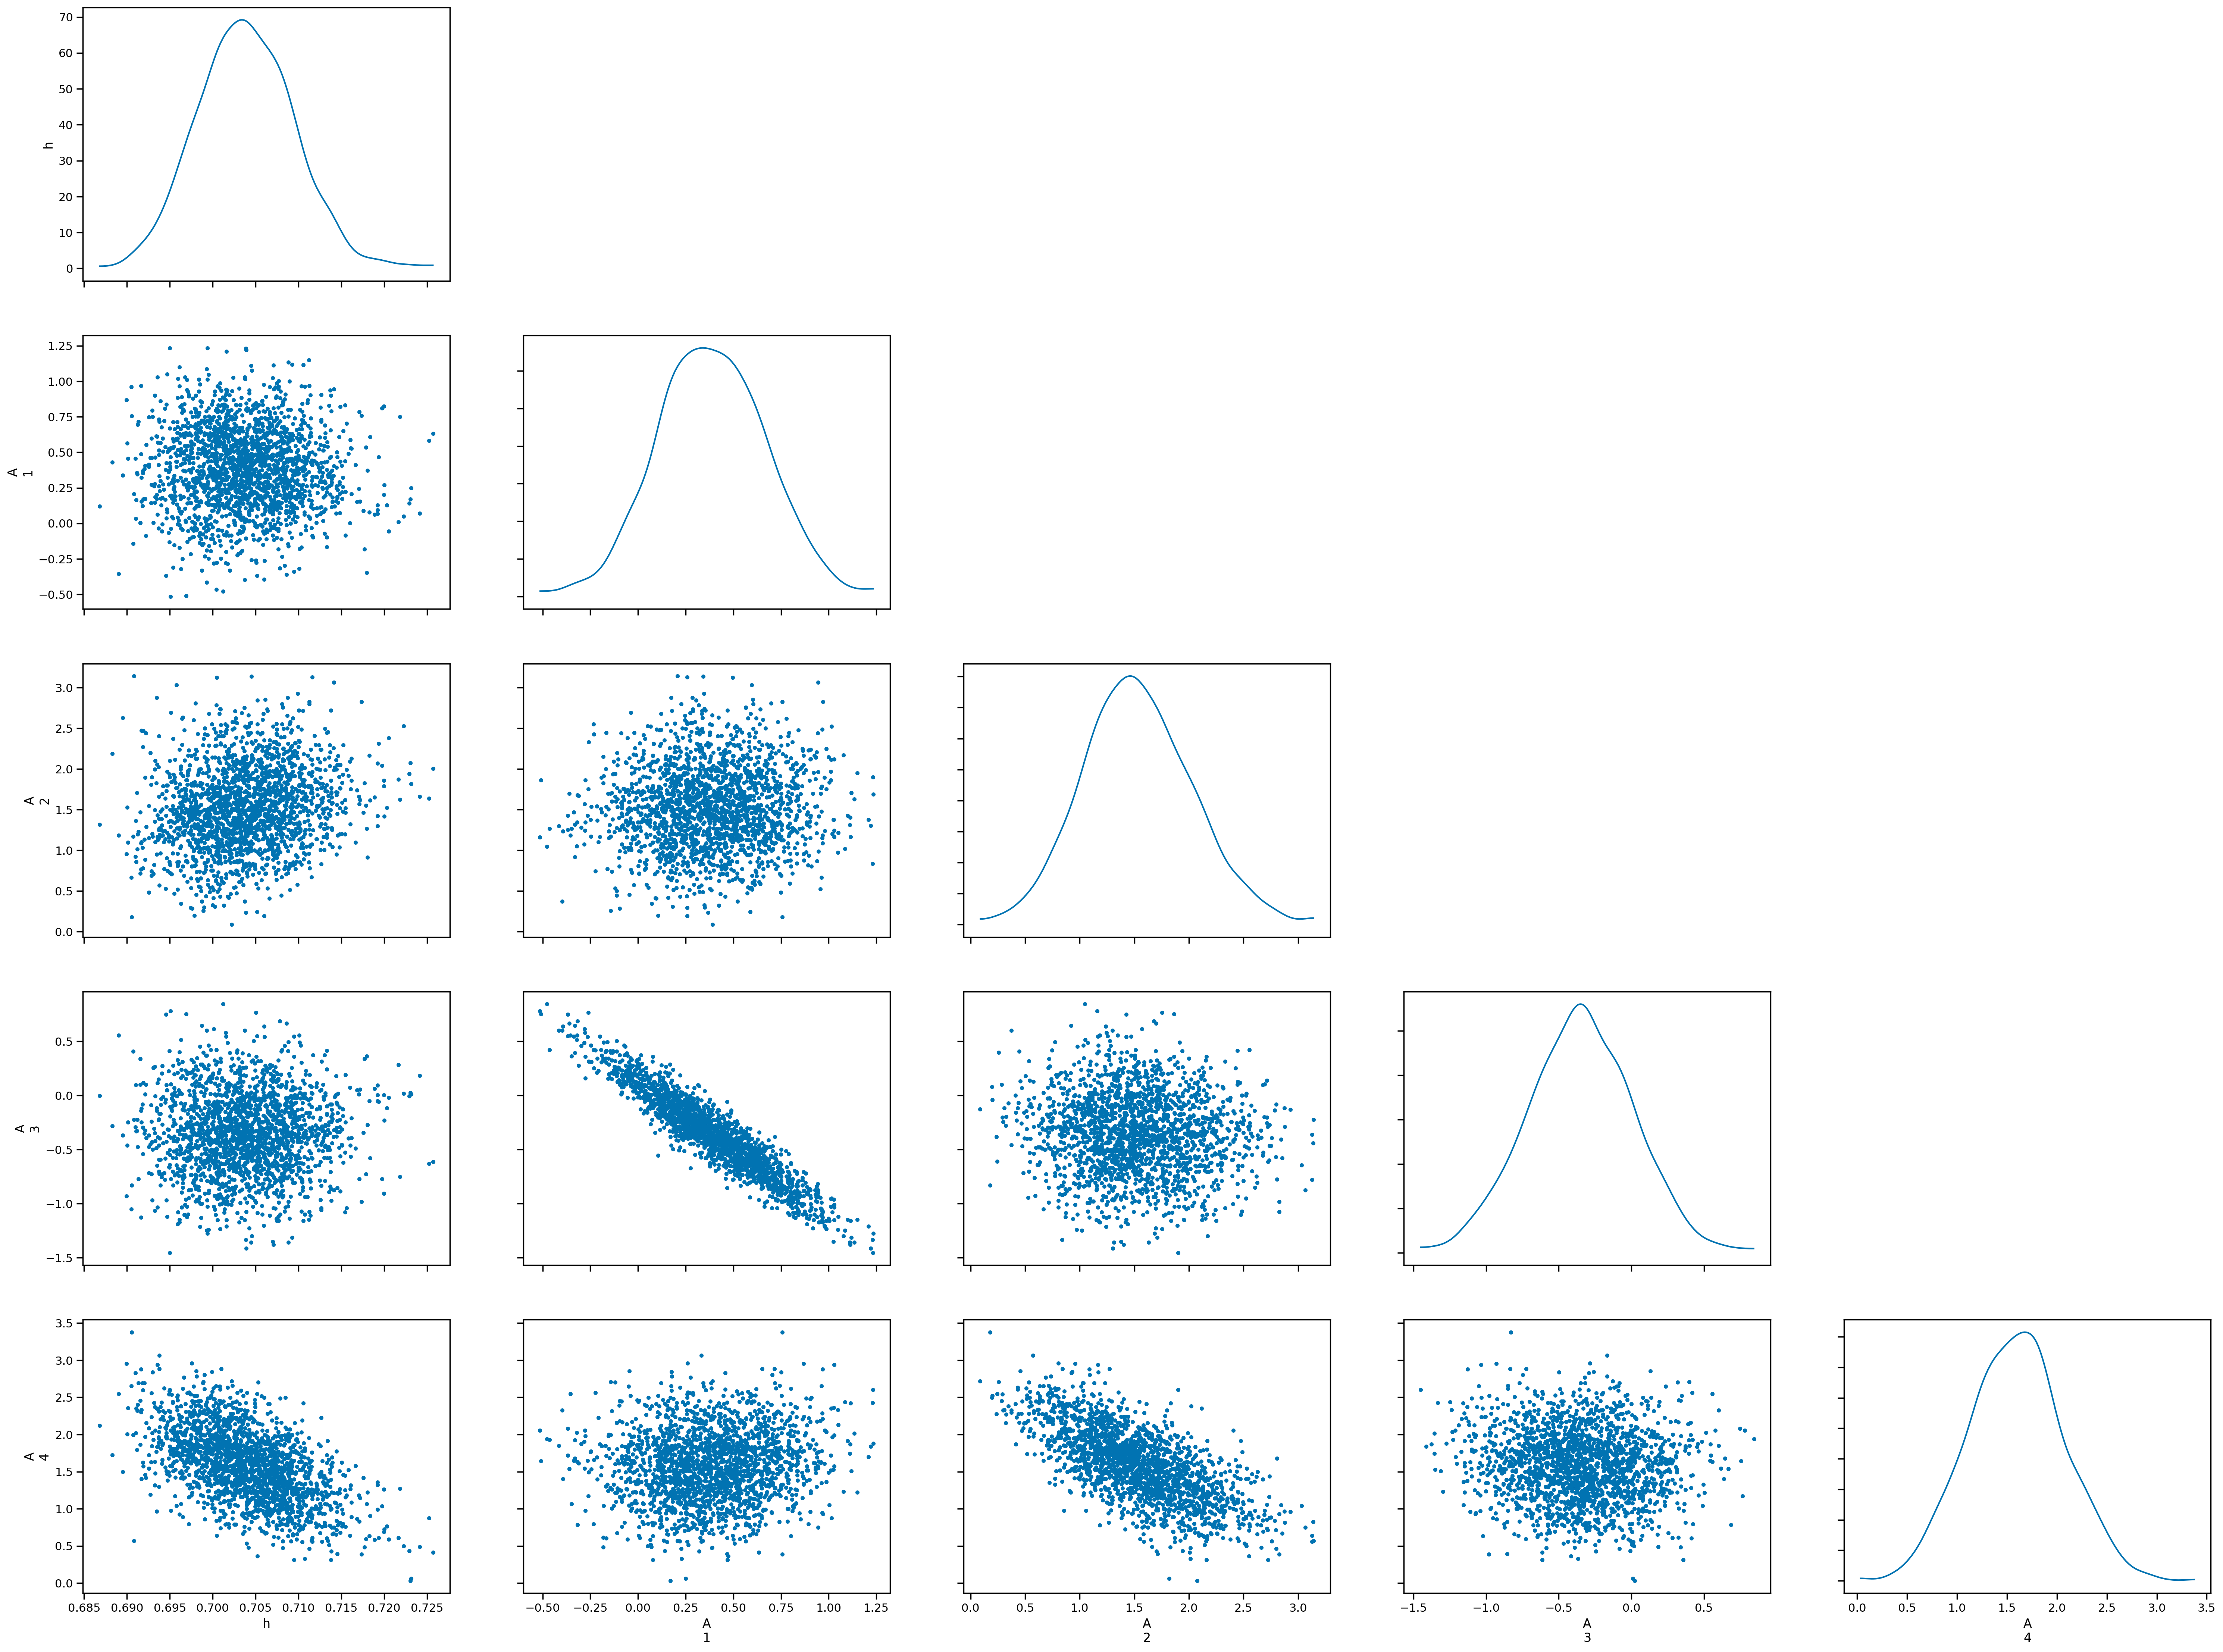

In [97]:
az.plot_pair(top_hat_trace, var_names=['h', 'A'], marginals=True)

In [98]:
if save_chains:
    az.to_netcdf(top_hat_flat_trace, op.join(outdir, 'top_hat_flat_inclination_chains.nc'))

Maya asks a very interesting question: what if we have the same number of GW events, but a more uniform inclination selection function.  Then we detect more EM counterparts, but lose out on inclination inference.  Is it better?  Let's at least compare for the current situation.  First, we need to figure out how many events *would* be in our catalog if we had a uniform inclination distribution.  The *fraction* of events with EM counterparts with our peaked distribution is 

In [99]:
print('Top hat detection efficiency {:.2f}'.format(np.sum(em_detected)/em_detected.shape[0]))

Top hat detection efficiency 0.15


In [101]:
Nflat = int(round(Ncatalog/0.15))
with models.make_model(z_true[1:Nflat], Al[1:Nflat], Ar[1:Nflat], x_true, Ndraw, N_A=4) as top_hat_flat_comparison:
    top_hat_flat_comparison_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [h, A, x]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 96 seconds.


In [105]:
models.calculate_P_det(top_hat_flat_comparison_trace)

Though $N_\mathrm{eff} < 4 N_\mathrm{obs}$, the fit looks good, so let's roll with it.

<AxesSubplot: title={'center': 'Neff'}>

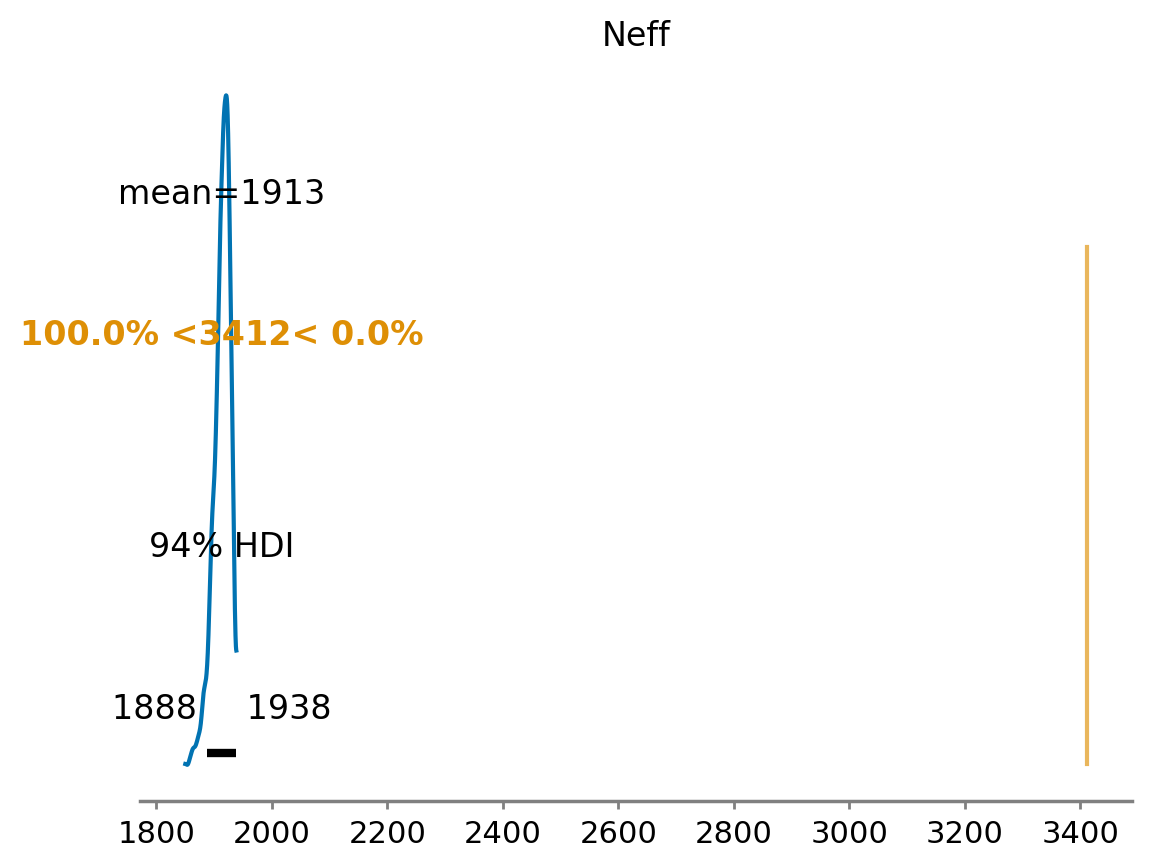

In [102]:
az.plot_posterior(top_hat_flat_comparison_trace, var_names='Neff', ref_val=4*Nflat)

array([[<AxesSubplot: title={'center': 'A'}>,
        <AxesSubplot: title={'center': 'A'}>],
       [<AxesSubplot: title={'center': 'h'}>,
        <AxesSubplot: title={'center': 'h'}>],
       [<AxesSubplot: title={'center': 'x'}>,
        <AxesSubplot: title={'center': 'x'}>],
       [<AxesSubplot: title={'center': 'd'}>,
        <AxesSubplot: title={'center': 'd'}>],
       [<AxesSubplot: title={'center': 'Neff'}>,
        <AxesSubplot: title={'center': 'Neff'}>]], dtype=object)

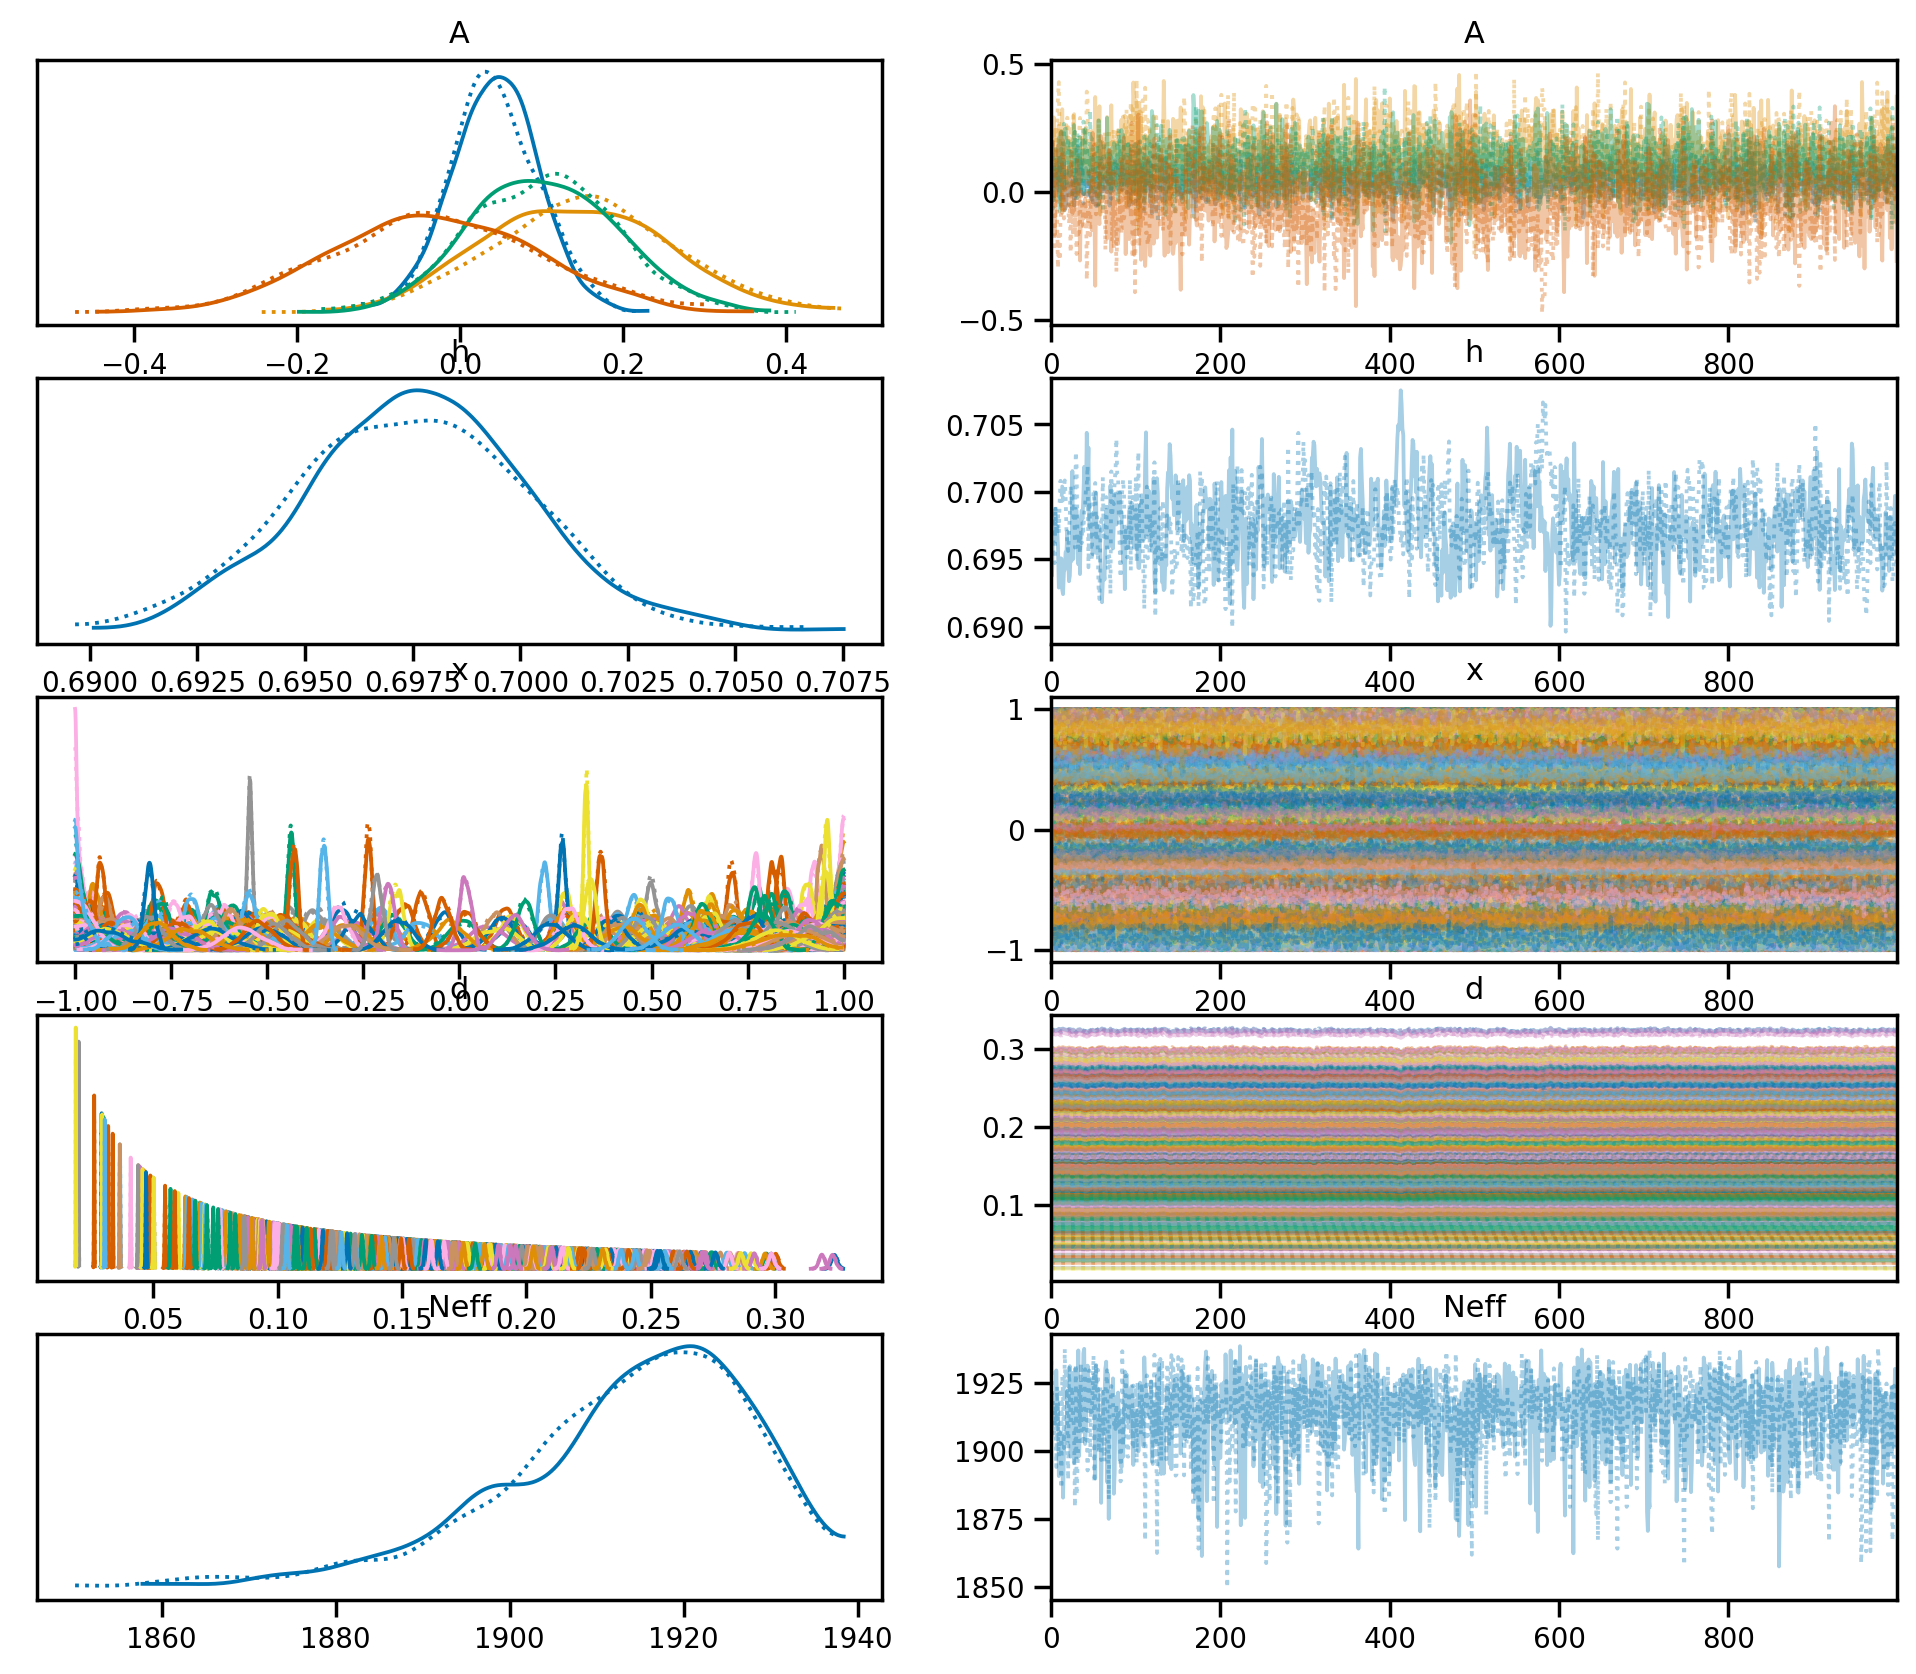

In [103]:
az.plot_trace(top_hat_flat_comparison_trace)

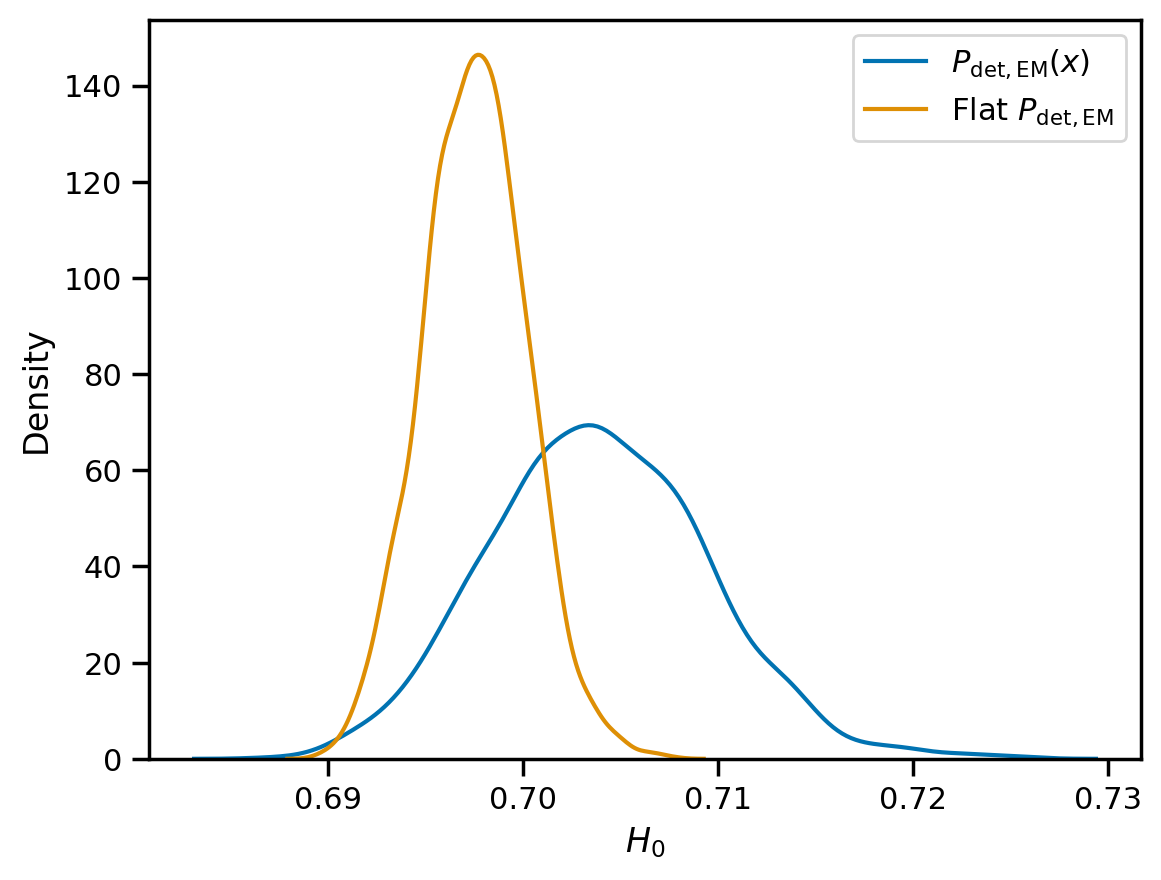

In [104]:
dims = ['chain', 'draw']
sns.kdeplot(top_hat_trace.posterior.h.stack(dim=dims), label=r'$P_{\mathrm{det},\mathrm{EM}}(x)$')
sns.kdeplot(top_hat_flat_comparison_trace.posterior.h.stack(dim=dims), label=r'Flat $P_{\mathrm{det},\mathrm{EM}}$')
plt.xlabel(r'$H_0$')
plt.legend()

Let's look at the inferred detection efficiency:

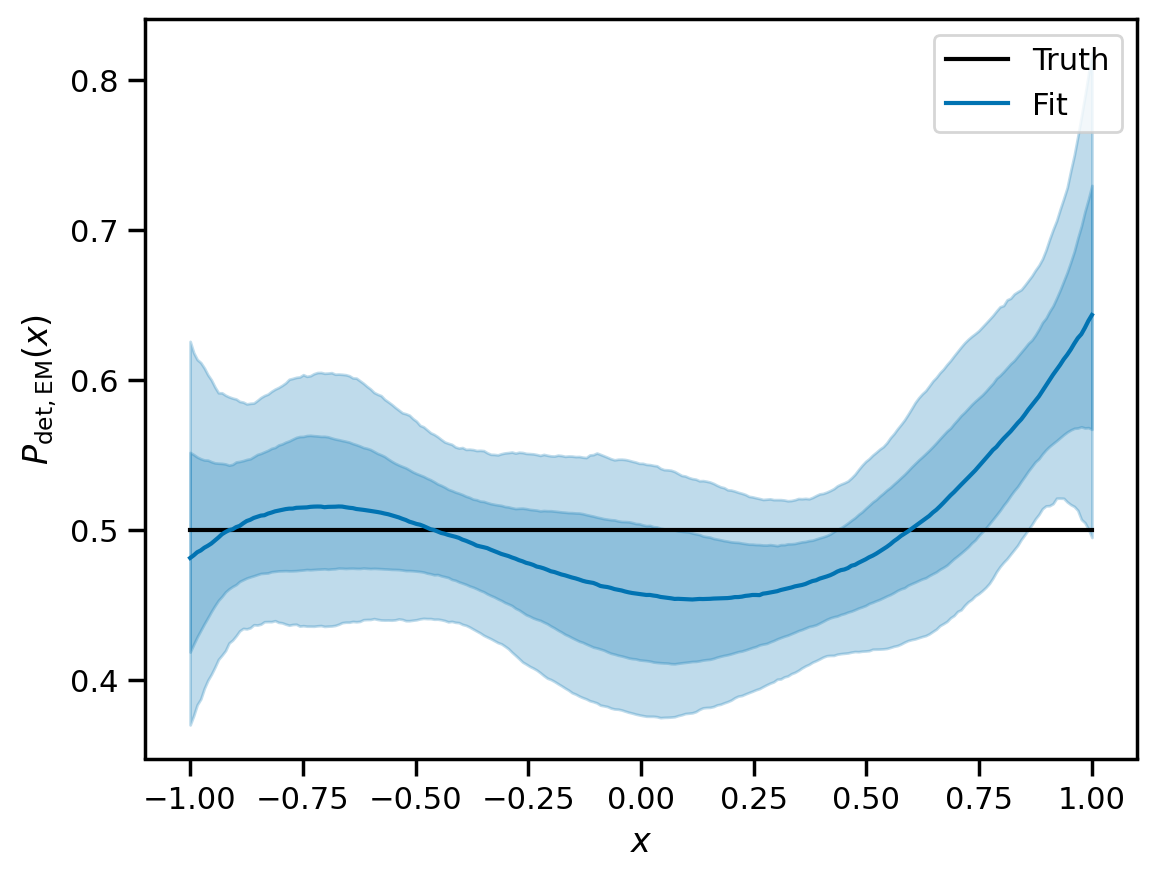

In [109]:
pd = top_hat_flat_comparison_trace.posterior.P_det
x = pd.coords['x']
d = ['chain', 'draw']
plt.plot(x, 0.5*np.ones_like(x), '-k', label='Truth')
l, plt.plot(x, pd.median(dim=d), label='Fit')
plt.fill_between(x, pd.quantile(0.84, dim=d), pd.quantile(0.16, dim=d), alpha=0.25, color=l.get_color())
plt.fill_between(x, pd.quantile(0.975, dim=d), pd.quantile(0.025, dim=d), alpha=0.25, color=l.get_color())
plt.xlabel(r'$x$')
plt.ylabel(r'$P_{\mathrm{det},\mathrm{EM}}(x)$')
plt.legend()

In [110]:
if save_chains:
    az.to_netcdf(top_hat_flat_comparison_trace, op.join(outdir, 'top_hat_flat_comparison.nc'))